<a href="https://colab.research.google.com/github/shanikairoshi/Communication-Efficient-DUQFL/blob/main/main_v2_genome_noniid_noTEleport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%capture
!pip install genomic-benchmarks
!pip install qiskit qiskit_machine_learning qiskit_algorithms qiskit-aer




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
from pathlib import Path
PROJ = Path.cwd() / "tduqfl_Project_AGG"
if str(PROJ) not in sys.path:
    sys.path.insert(0, str(PROJ))
import sys
sys.path.append('/content/drive/MyDrive/Teleportation/tduqfl_Project_AGG/tDuQFL_Project')
# ─── 5. Assemble filenames for each artifact ─────────────────────────────────
#drive_root = "/content/drive/MyDrive/Teleportation/tduqfl_Project_AGG/tDuQFL_Project/"

In [8]:
from common.imports import *
#from configs.dataset_genome import *     # swap to other configs as needed
from io_utils.naming import stamp_now, flags, build_param_str, make_filenames
from data.preprocess_genome import load_and_prepare_dataset
from configs.base_config import *
from data.splitters import split_dataset_for_epochs
from configs.base_config import (
    num_clients, num_epochs, samples_per_epoch,
    global_seed,client_hparams_csv_file,split_type,dataset_name,use_teleportation,use_noise,num_federated_layers
)

start_str, date_str = stamp_now()
teleport_pl, noise_pl = flags(use_teleportation, use_noise)
param_str = build_param_str(num_clients, num_federated_layers, num_deep_unfolding_iterations,
                            initial_learning_rate, initial_perturbation)

# Modified make_filenames to include split_type
best_client_csv_file, global_csv_file, local_csv_file, validation_csv_file = make_filenames(
    drive_root, dataset_name, split_type, date_str, teleport_pl, noise_pl, param_str
)
from io_utils.csv_logger import init_local_csv, init_best_csv, init_validation_csv

# Create folders + write headers
init_best_csv(best_client_csv_file)

local_headers = [
    "Federated Round", "Client Number", "Iteration",
    "Objective Function Value", "Training Accuracy", "Test Accuracy",
    "Learning Rate", "Perturbation"
]
init_local_csv(local_csv_file, local_headers)

init_validation_csv(validation_csv_file)

# Do NOT pre-init global_csv_file here because your save_accuracies_to_csv()
# already writes the header each time it runs (in 'w' mode).

Load and Split data

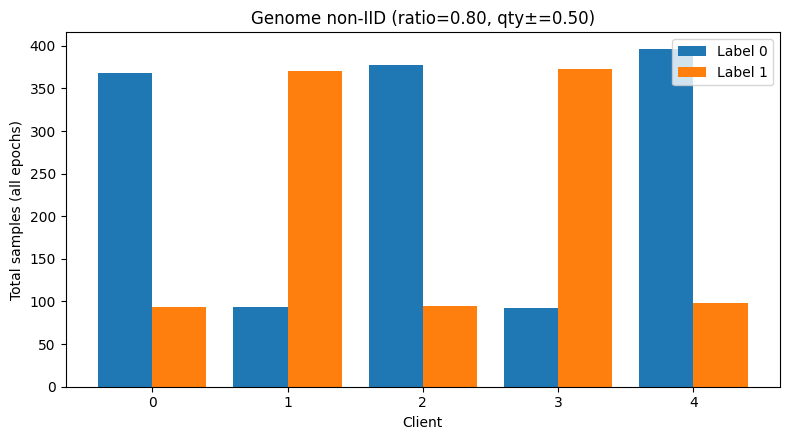

In [9]:


np_train_data, np_test_data = load_and_prepare_dataset(word_size, global_seed)

# 2) Compute feasible epoch capacity and cap both epochs and rounds
N_train = len(np_train_data)
train_capacity = N_train // (num_clients * samples_per_epoch)
num_epochs_eff = max(1, min(num_epochs, train_capacity))

if train_capacity == 0:
    raise ValueError(
        f"Not enough training samples ({N_train}) for "
        f"{num_clients=} × {samples_per_epoch=} per epoch. "
        "Reduce samples_per_epoch or num_clients, or enable resampling."
    )

num_federated_layers_eff = min(num_federated_layers, num_epochs_eff)

# Build clients
if split_type.lower() == "iid":
    from data.splitters import split_dataset_for_epochs
    clients = split_dataset_for_epochs(
        num_clients=num_clients,
        num_epochs=num_epochs_eff,             # or num_epochs
        train_data=np_train_data,
        test_data=np_test_data,
        samples_per_epoch=samples_per_epoch,
    )
elif split_type.lower() in {"noniid", "non-iid", "non_iid"}:
    from data.noniid import make_non_iid_clients
    clients = make_non_iid_clients(
        train_data=np_train_data,
        test_data=np_test_data,
        num_clients=num_clients,
        num_epochs=num_epochs_eff,             # or num_epochs
        samples_per_epoch=samples_per_epoch,
        non_iid_ratio=0.8,                     # tune as needed
        quantity_variation=0.5,                # tune as needed
        seed=global_seed,
        plot=True
    )
else:
    raise ValueError(f"Unknown split_type: {split_type}")

'''
clients = split_dataset_for_epochs(
    num_clients=num_clients, num_epochs=num_epochs,
    train_data=np_train_data, test_data=np_test_data,
    samples_per_epoch=samples_per_epoch
)
'''
# validation/tables
test_sequences = np.array([d["sequence"] for d in np_test_data])
test_labels    = np.array([d["label"]    for d in np_test_data])
X_val, y_val   = test_sequences, test_labels

# derive num_features once
if clients and clients[0].data and clients[0].data[0]:
    num_features = clients[0].data[0][0]['sequence'].shape[0]
else:
    raise RuntimeError("Empty client data – check splitting indices.")


In [10]:
# Infer num_features from the first available sample in clients
def infer_num_features_from_clients(clients):
    for c in clients:
        for epoch_data in c.data:              # list of samples for that epoch
            if not epoch_data:
                continue
            sample = epoch_data[0]
            if "sequence" in sample:           # your Genome pipeline
                arr = np.asarray(sample["sequence"])
                return int(arr.size)
            if "features" in sample:           # some other pipelines
                arr = np.asarray(sample["features"])
                return int(arr.size)
            if "image" in sample:              # e.g., MNIST before flatten
                arr = np.asarray(sample["image"]).reshape(-1)
                return int(arr.size)
            # add any other key you use
    raise RuntimeError("Could not infer num_features: no samples found.")

num_features = infer_num_features_from_clients(clients)
print(f"[info] num_features = {num_features}")


[info] num_features = 5


run federated loop and plot

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

[Round 0] Teleportation OFF | Aggregation=best
[round 0 | client 0] seed LR=0.1400000000 (prev=0.1400000000), seed PERT=0.1400000000 (prev=0.1400000000), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.500761 step=0.01057 g_raw=+0.003 g_sm=+0.000 acc=1 | LR→0.140280 PERT→0.140000 (scale=0.04)
[meta] cb#010 loss=0.490114 step=0.04293 g_raw=+0.011 g_sm=+0.006 acc=1 | LR→0.140561 PERT→0.140000 (scale=0.04)
[meta] cb#015 loss=0.482862 step=0.06813 g_raw=+0.029 g_sm=+0.009 acc=1 | LR→0.140843 PERT→0.140000 (scale=0.04)
[meta] cb#020 loss=0.478602 step=0.04595 g_raw=+0.017 g_sm=+0.011 acc=1 | LR→0.141125 PERT→0.140001 (scale=0.04)
[meta] cb#025 loss=0.473317 step=0.02601 g_raw=+0.016 g_sm=+0.013 acc=1 | LR→0.141408 PERT→0.140001 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1400000000, PERT_used=0.1400000000 → LR_next=0.1414079725, PERT_next=0.1400009396
[meta-summary] callbacks=25 g_raw_mean=+0.017 g_sm_mean=+0.007 acc_ratio=1.00 | LR 0.1400000000→0.1414079725 PERT 0.140000000

Training Progress:  10%|█         | 1/10 [19:12<2:52:55, 1152.79s/it]

[Round   0] acc_g=0.504 (μ=0.500, σ=0.005, FG=0.011) | t=1134.854s, val=0.736 | TEL=FALSE
[Round 1] Teleportation OFF | Aggregation=best
[round 1 | client 0] seed LR=0.1435951024 (prev=0.1471902049), seed PERT=0.1400058269 (prev=0.1400116539), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.527977 step=0.07879 g_raw=+0.031 g_sm=+0.004 acc=1 | LR→0.143883 PERT→0.140006 (scale=0.04)
[meta] cb#010 loss=0.510686 step=0.1769 g_raw=+0.066 g_sm=+0.010 acc=1 | LR→0.144171 PERT→0.140006 (scale=0.04)
[meta] cb#015 loss=0.492599 step=0.07595 g_raw=+0.024 g_sm=+0.015 acc=1 | LR→0.144460 PERT→0.140006 (scale=0.04)
[meta] cb#020 loss=0.467268 step=0.03375 g_raw=+0.011 g_sm=+0.020 acc=1 | LR→0.144750 PERT→0.140007 (scale=0.04)
[meta] cb#025 loss=0.456619 step=0.09559 g_raw=+0.037 g_sm=+0.021 acc=1 | LR→0.145040 PERT→0.140008 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1435951024, PERT_used=0.1400058269 → LR_next=0.1450400156, PERT_next=0.1400075243
[meta-summary] callbacks=25 g_raw_me

Training Progress:  20%|██        | 2/10 [38:02<2:31:53, 1139.21s/it]

[Round   1] acc_g=0.507 (μ=0.512, σ=0.026, FG=0.046) | t=1112.163s, val=0.724 | TEL=FALSE
[Round 2] Teleportation OFF | Aggregation=best
[round 2 | client 0] seed LR=0.1454854546 (prev=0.1509709093), seed PERT=0.1400091870 (prev=0.1400183740), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.451459 step=0.06698 g_raw=+0.020 g_sm=+0.002 acc=1 | LR→0.145777 PERT→0.140009 (scale=0.04)
[meta] cb#010 loss=0.430190 step=0.07066 g_raw=+0.029 g_sm=+0.009 acc=1 | LR→0.146069 PERT→0.140009 (scale=0.04)
[meta] cb#015 loss=0.421633 step=0.02837 g_raw=+0.009 g_sm=+0.010 acc=1 | LR→0.146362 PERT→0.140010 (scale=0.04)
[meta] cb#020 loss=0.393148 step=0.1881 g_raw=+0.066 g_sm=+0.016 acc=1 | LR→0.146655 PERT→0.140010 (scale=0.04)
[meta] cb#025 loss=0.378141 step=0.03936 g_raw=+0.012 g_sm=+0.018 acc=1 | LR→0.146949 PERT→0.140011 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1454854546, PERT_used=0.1400091870 → LR_next=0.1469490547, PERT_next=0.1400105656
[meta-summary] callbacks=25 g_raw_me

Training Progress:  30%|███       | 3/10 [58:31<2:17:41, 1180.21s/it]

[Round   2] acc_g=0.599 (μ=0.505, σ=0.016, FG=0.029) | t=1211.134s, val=0.685 | TEL=FALSE
[Round 3] Teleportation OFF | Aggregation=best
[round 3 | client 0] seed LR=0.1464783369 (prev=0.1529566737), seed PERT=0.1400100953 (prev=0.1400201907), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.531519 step=0.1916 g_raw=+0.069 g_sm=+0.011 acc=1 | LR→0.146772 PERT→0.140010 (scale=0.04)
[meta] cb#010 loss=0.503695 step=0.05764 g_raw=+0.029 g_sm=+0.016 acc=1 | LR→0.147066 PERT→0.140011 (scale=0.04)
[meta] cb#015 loss=0.483498 step=0.009722 g_raw=+0.001 g_sm=+0.020 acc=1 | LR→0.147361 PERT→0.140011 (scale=0.04)
[meta] cb#020 loss=0.473212 step=0.01367 g_raw=+0.008 g_sm=+0.021 acc=1 | LR→0.147657 PERT→0.140012 (scale=0.04)
[meta] cb#025 loss=0.459670 step=0.07443 g_raw=+0.024 g_sm=+0.023 acc=1 | LR→0.147953 PERT→0.140012 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1464783369, PERT_used=0.1400100953 → LR_next=0.1479528596, PERT_next=0.1400123579
[meta-summary] callbacks=25 g_raw_m

Training Progress:  40%|████      | 4/10 [1:19:37<2:01:23, 1213.94s/it]

[Round   3] acc_g=0.796 (μ=0.511, σ=0.020, FG=0.039) | t=1248.616s, val=0.626 | TEL=FALSE
[Round 4] Teleportation OFF | Aggregation=best
[round 4 | client 0] seed LR=0.1470012595 (prev=0.1540025189), seed PERT=0.1400114473 (prev=0.1400228946), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.561803 step=0.09171 g_raw=+0.038 g_sm=+0.004 acc=1 | LR→0.147296 PERT→0.140011 (scale=0.04)
[meta] cb#010 loss=0.511205 step=0.05724 g_raw=+0.022 g_sm=+0.014 acc=1 | LR→0.147591 PERT→0.140012 (scale=0.04)
[meta] cb#015 loss=0.486721 step=0.06756 g_raw=+0.021 g_sm=+0.020 acc=1 | LR→0.147887 PERT→0.140012 (scale=0.04)
[meta] cb#020 loss=0.471379 step=0.03213 g_raw=+0.012 g_sm=+0.022 acc=1 | LR→0.148184 PERT→0.140013 (scale=0.04)
[meta] cb#025 loss=0.432511 step=0.07685 g_raw=+0.028 g_sm=+0.026 acc=1 | LR→0.148481 PERT→0.140014 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1470012595, PERT_used=0.1400114473 → LR_next=0.1484808922, PERT_next=0.1400135648
[meta-summary] callbacks=25 g_raw_m

Training Progress:  50%|█████     | 5/10 [1:38:47<1:39:14, 1190.97s/it]

[Round   4] acc_g=0.711 (μ=0.518, σ=0.031, FG=0.060) | t=1133.157s, val=0.623 | TEL=FALSE
[Round 5] Teleportation OFF | Aggregation=best
[round 5 | client 0] seed LR=0.1472768322 (prev=0.1545536645), seed PERT=0.1400127403 (prev=0.1400254806), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.476458 step=0.004974 g_raw=+0.000 g_sm=+0.004 acc=1 | LR→0.147572 PERT→0.140013 (scale=0.04)
[meta] cb#010 loss=0.447275 step=0.139 g_raw=+0.055 g_sm=+0.012 acc=1 | LR→0.147867 PERT→0.140013 (scale=0.04)
[meta] cb#015 loss=0.438030 step=0.05592 g_raw=+0.021 g_sm=+0.013 acc=1 | LR→0.148164 PERT→0.140013 (scale=0.04)
[meta] cb#020 loss=0.422791 step=0.02767 g_raw=+0.010 g_sm=+0.017 acc=1 | LR→0.148461 PERT→0.140014 (scale=0.04)
[meta] cb#025 loss=0.410474 step=0.02744 g_raw=+0.009 g_sm=+0.018 acc=1 | LR→0.148759 PERT→0.140014 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1472768322, PERT_used=0.1400127403 → LR_next=0.1487587330, PERT_next=0.1400143818
[meta-summary] callbacks=25 g_raw_me

Training Progress:  60%|██████    | 6/10 [1:53:26<1:12:20, 1085.02s/it]

[Round   5] acc_g=0.764 (μ=0.499, σ=0.005, FG=0.011) | t=861.052s, val=0.619 | TEL=FALSE
[Round 6] Teleportation OFF | Aggregation=best
[round 6 | client 0] seed LR=0.1474201027 (prev=0.1548402054), seed PERT=0.1400119445 (prev=0.1400238891), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.486556 step=0.04287 g_raw=+0.016 g_sm=+0.001 acc=1 | LR→0.147715 PERT→0.140012 (scale=0.04)
[meta] cb#010 loss=0.479719 step=0.03583 g_raw=+0.011 g_sm=+0.006 acc=1 | LR→0.148011 PERT→0.140012 (scale=0.04)
[meta] cb#015 loss=0.474111 step=0.01451 g_raw=+0.004 g_sm=+0.008 acc=1 | LR→0.148308 PERT→0.140012 (scale=0.04)
[meta] cb#020 loss=0.467970 step=0.05359 g_raw=+0.022 g_sm=+0.010 acc=1 | LR→0.148605 PERT→0.140013 (scale=0.04)
[meta] cb#025 loss=0.462513 step=0.06543 g_raw=+0.021 g_sm=+0.012 acc=1 | LR→0.148903 PERT→0.140013 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1474201027, PERT_used=0.1400119445 → LR_next=0.1489026768, PERT_next=0.1400128637
[meta-summary] callbacks=25 g_raw_me

Training Progress:  70%|███████   | 7/10 [2:12:21<55:04, 1101.38s/it]  

[Round   6] acc_g=0.771 (μ=0.497, σ=0.008, FG=0.018) | t=1117.789s, val=0.637 | TEL=FALSE
[Round 7] Teleportation OFF | Aggregation=best
[round 7 | client 0] seed LR=0.1474947673 (prev=0.1549895347), seed PERT=0.1400109600 (prev=0.1400219199), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.507980 step=0.2188 g_raw=+0.084 g_sm=+0.009 acc=1 | LR→0.147790 PERT→0.140011 (scale=0.04)
[meta] cb#010 loss=0.498846 step=0.03918 g_raw=+0.015 g_sm=+0.013 acc=1 | LR→0.148086 PERT→0.140011 (scale=0.04)
[meta] cb#015 loss=0.491176 step=0.03673 g_raw=+0.018 g_sm=+0.014 acc=1 | LR→0.148383 PERT→0.140012 (scale=0.04)
[meta] cb#020 loss=0.450891 step=0.002079 g_raw=+0.001 g_sm=+0.021 acc=1 | LR→0.148681 PERT→0.140012 (scale=0.04)
[meta] cb#025 loss=0.418855 step=0.03164 g_raw=+0.009 g_sm=+0.025 acc=1 | LR→0.148979 PERT→0.140013 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1474947673, PERT_used=0.1400109600 → LR_next=0.1489792394, PERT_next=0.1400129571
[meta-summary] callbacks=25 g_raw_m

Training Progress:  80%|████████  | 8/10 [2:29:02<35:38, 1069.40s/it]

[Round   7] acc_g=0.762 (μ=0.504, σ=0.008, FG=0.018) | t=982.874s, val=0.633 | TEL=FALSE
[Round 8] Teleportation OFF | Aggregation=best
[round 8 | client 0] seed LR=0.1475349648 (prev=0.1550699296), seed PERT=0.1400113239 (prev=0.1400226478), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.447152 step=0.1222 g_raw=+0.047 g_sm=+0.008 acc=1 | LR→0.147830 PERT→0.140011 (scale=0.04)
[meta] cb#010 loss=0.430158 step=0.012 g_raw=+0.009 g_sm=+0.012 acc=1 | LR→0.148127 PERT→0.140012 (scale=0.04)
[meta] cb#015 loss=0.379134 step=0.04707 g_raw=+0.015 g_sm=+0.021 acc=1 | LR→0.148424 PERT→0.140012 (scale=0.04)
[meta] cb#020 loss=0.370411 step=0.02089 g_raw=+0.010 g_sm=+0.021 acc=1 | LR→0.148722 PERT→0.140013 (scale=0.04)
[meta] cb#025 loss=0.356987 step=0.01925 g_raw=+0.001 g_sm=+0.021 acc=1 | LR→0.149020 PERT→0.140013 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1475349648, PERT_used=0.1400113239 → LR_next=0.1490199391, PERT_next=0.1400134128
[meta-summary] callbacks=25 g_raw_mean=

Training Progress:  90%|█████████ | 9/10 [2:46:42<17:46, 1066.25s/it]

[Round   8] acc_g=0.771 (μ=0.503, σ=0.012, FG=0.023) | t=1042.184s, val=0.632 | TEL=FALSE
[Round 9] Teleportation OFF | Aggregation=best
[round 9 | client 0] seed LR=0.1475556666 (prev=0.1551113332), seed PERT=0.1400111184 (prev=0.1400222369), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.428741 step=0.09928 g_raw=+0.035 g_sm=+0.004 acc=1 | LR→0.147851 PERT→0.140011 (scale=0.04)
[meta] cb#010 loss=0.424198 step=0.05026 g_raw=+0.022 g_sm=+0.006 acc=1 | LR→0.148147 PERT→0.140011 (scale=0.04)
[meta] cb#015 loss=0.383941 step=0.1555 g_raw=+0.051 g_sm=+0.016 acc=1 | LR→0.148444 PERT→0.140012 (scale=0.04)
[meta] cb#020 loss=0.362020 step=0.1641 g_raw=+0.067 g_sm=+0.020 acc=1 | LR→0.148742 PERT→0.140012 (scale=0.04)
[meta] cb#025 loss=0.332747 step=0.08799 g_raw=+0.029 g_sm=+0.025 acc=1 | LR→0.149040 PERT→0.140013 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1475556666, PERT_used=0.1400111184 → LR_next=0.1490403548, PERT_next=0.1400127428
[meta-summary] callbacks=25 g_raw_mea

Training Progress: 100%|██████████| 10/10 [3:01:16<00:00, 1087.63s/it]

[Round   9] acc_g=0.688 (μ=0.552, σ=0.089, FG=0.160) | t=856.301s, val=0.604 | TEL=FALSE


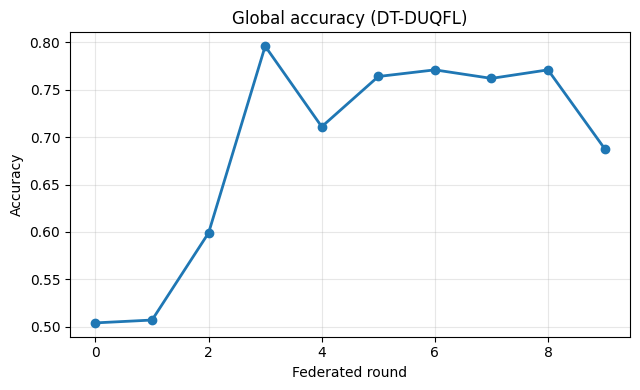

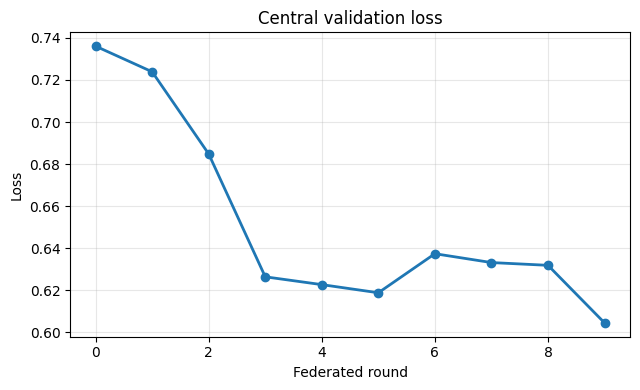

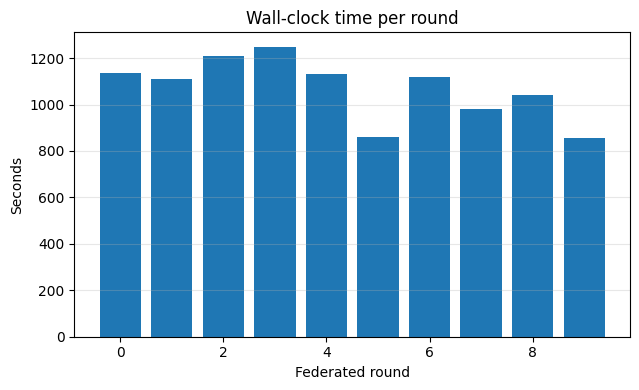

In [11]:
from training.loop import run_federated_training
from configs.base_config import use_teleportation as CFG_TEL, noise_preset, shots_used,aggregation,client_hparams_csv_file
from training.metrics import metrics_init, metrics_log_round, metrics_finalize, compute_auc,metrics_summarize
from viz.plots import plot_accuracy_curve, plot_val_loss, plot_time_per_round, plot_fidelity_vs_delta_acc, plot_beta_hist, plot_client_fairness_last_round
# Initialize metrics store once
metrics_store = metrics_init(
    log_path=os.path.join(drive_root, "teleport_metrics_Perturb_shrink.csv")
)

#new
from ml import optimizers as mlopt
from configs.base_config import drive_root
import os

mlopt.meta_trace_enable(
    path=os.path.join(drive_root, "meta_trace.csv"),  # or None to skip CSV
    every=5                                           # print every 5 callbacks
)

###########
global_acc, clients_train, clients_test, round_times, val_losses, info_last = run_federated_training(
    clients=clients,
    num_federated_layers=num_federated_layers,
    num_deep_unfolding_iterations=num_deep_unfolding_iterations,
    initial_learning_rate=initial_learning_rate,
    initial_perturbation=initial_perturbation,
    num_features=num_features,
    best_client_csv_file=best_client_csv_file,
    global_csv_file=global_csv_file,
    local_csv_file=local_csv_file,
    validation_csv_file=validation_csv_file,
    test_sequences=test_sequences,
    test_labels=test_labels,
    X_val=X_val,
    y_val=y_val,
    use_teleportation=CFG_TEL,          # ← important
    noise_preset=noise_preset,
    shots_used=shots_used,
    metrics=metrics_store,   # <-- pass it in
    aggregation=aggregation,
    client_hparams_csv_file=client_hparams_csv_file,   # <-- NEW# <--- switch here
)

rows_np = metrics_finalize(metrics_store)   # if you need the in-memory array
#summary = metrics_summarize(metrics_store)  # prints a concise summary, returns a dict

# quick visuals
rounds = list(range(len(global_acc)))
plot_accuracy_curve(rounds, global_acc, label="Global accuracy (DT-DUQFL)")
plot_val_loss(rounds, val_losses, label="Central validation loss")
plot_time_per_round(rounds, round_times)

if info_last is not None:
    # this uses "last" round's info; in your logger you kept per-round arrays; adapt if needed
    pass
